In [3]:
from elliot.run import run_experiment
import zipfile
import io
import requests
import os
import pandas as pd
import numpy as np

import pandas as pd
pd.options.display.max_rows = 100
import numpy as np
import os
from lenskit import crossfold as xf
from data_generation import generate_data
from itertools import chain
from lenskit import util, batch, topn
import modelling_mf


__/\\\\\\\\\\\\\\\___/\\\\\\______/\\\\\\_________________________________________        
 _\/\\\///////////___\////\\\_____\////\\\_________________________________________       
  _\/\\\_________________\/\\\________\/\\\______/\\\_____________________/\\\______      
   _\/\\\\\\\\\\\_________\/\\\________\/\\\_____\///_______/\\\\\______/\\\\\\\\\\\_     
    _\/\\\///////__________\/\\\________\/\\\______/\\\____/\\\///\\\___\////\\\////__    
     _\/\\\_________________\/\\\________\/\\\_____\/\\\___/\\\__\//\\\_____\/\\\______   
      _\/\\\_________________\/\\\________\/\\\_____\/\\\__\//\\\__/\\\______\/\\\_/\\__  
       _\/\\\\\\\\\\\\\\\___/\\\\\\\\\___/\\\\\\\\\__\/\\\___\///\\\\\/_______\//\\\\\___ 
        _\///////////////___\/////////___\/////////___\///______\/////__________\/////____
Version Number: 0.3.1


In [15]:
data="fairbook"
# user-item interactions
fairbook_ratings = pd.read_csv("elliot/data/fairbook/"+data+"_events.csv")

user_col = "user" # the name of the column that includes the users
item_col = "item" # the name of the column that includes the items
predict_col="rating" # the name of the column that includes the interaction

#### Pop good 1

In [67]:
filename = 'NGCF_seed=42_e=50_bs=256_lr=0$0001_factors=64_l_w=0$1_weight_size=64_node_dropout=_message_dropout=0$1_n_fold=5_it=50.tsv'

In [68]:
data="fairbook"
# user-item interactions
fairbook_ratings = pd.read_csv("elliot/data/fairbook/"+data+"_events.csv")

In [69]:
user_col = "user" # the name of the column that includes the users
item_col = "item" # the name of the column that includes the items
predict_col="rating" # the name of the column that includes the interaction

In [70]:
data_strategies = [
                   'popularity_good',
                   ]

In [71]:
location = 'elliot/results/pop_good1/recs/'

In [72]:
ratings = generate_data(strategy = data_strategies[0],
                            copying_dataset = fairbook_ratings,
                            user_perc = 0.2)

In [73]:
all_items=set(ratings.item.unique())

elliot/results/pop_good1/recs/NGCF_seed=42_e=50_bs=256_lr=0$0001_factors=64_l_w=0$1_weight_size=64_node_dropout=_message_dropout=0$1_n_fold=5_it=50.tsv


2024-02-20 14:34:42.442556: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcudart.so.10.1'; dlerror: libcudart.so.10.1: cannot open shared object file: No such file or directory
2024-02-20 14:34:42.442603: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2024-02-20 14:34:42.693176: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcudart.so.10.1'; dlerror: libcudart.so.10.1: cannot open shared object file: No such file or directory
2024-02-20 14:34:42.693211: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2024-02-20 14:34:42.879462: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcudart.so.10.1'; dlerror: libcudart.so.10.1: cannot open shared object file: No such file or dire

nr of longtail 7663
6.02437106918239


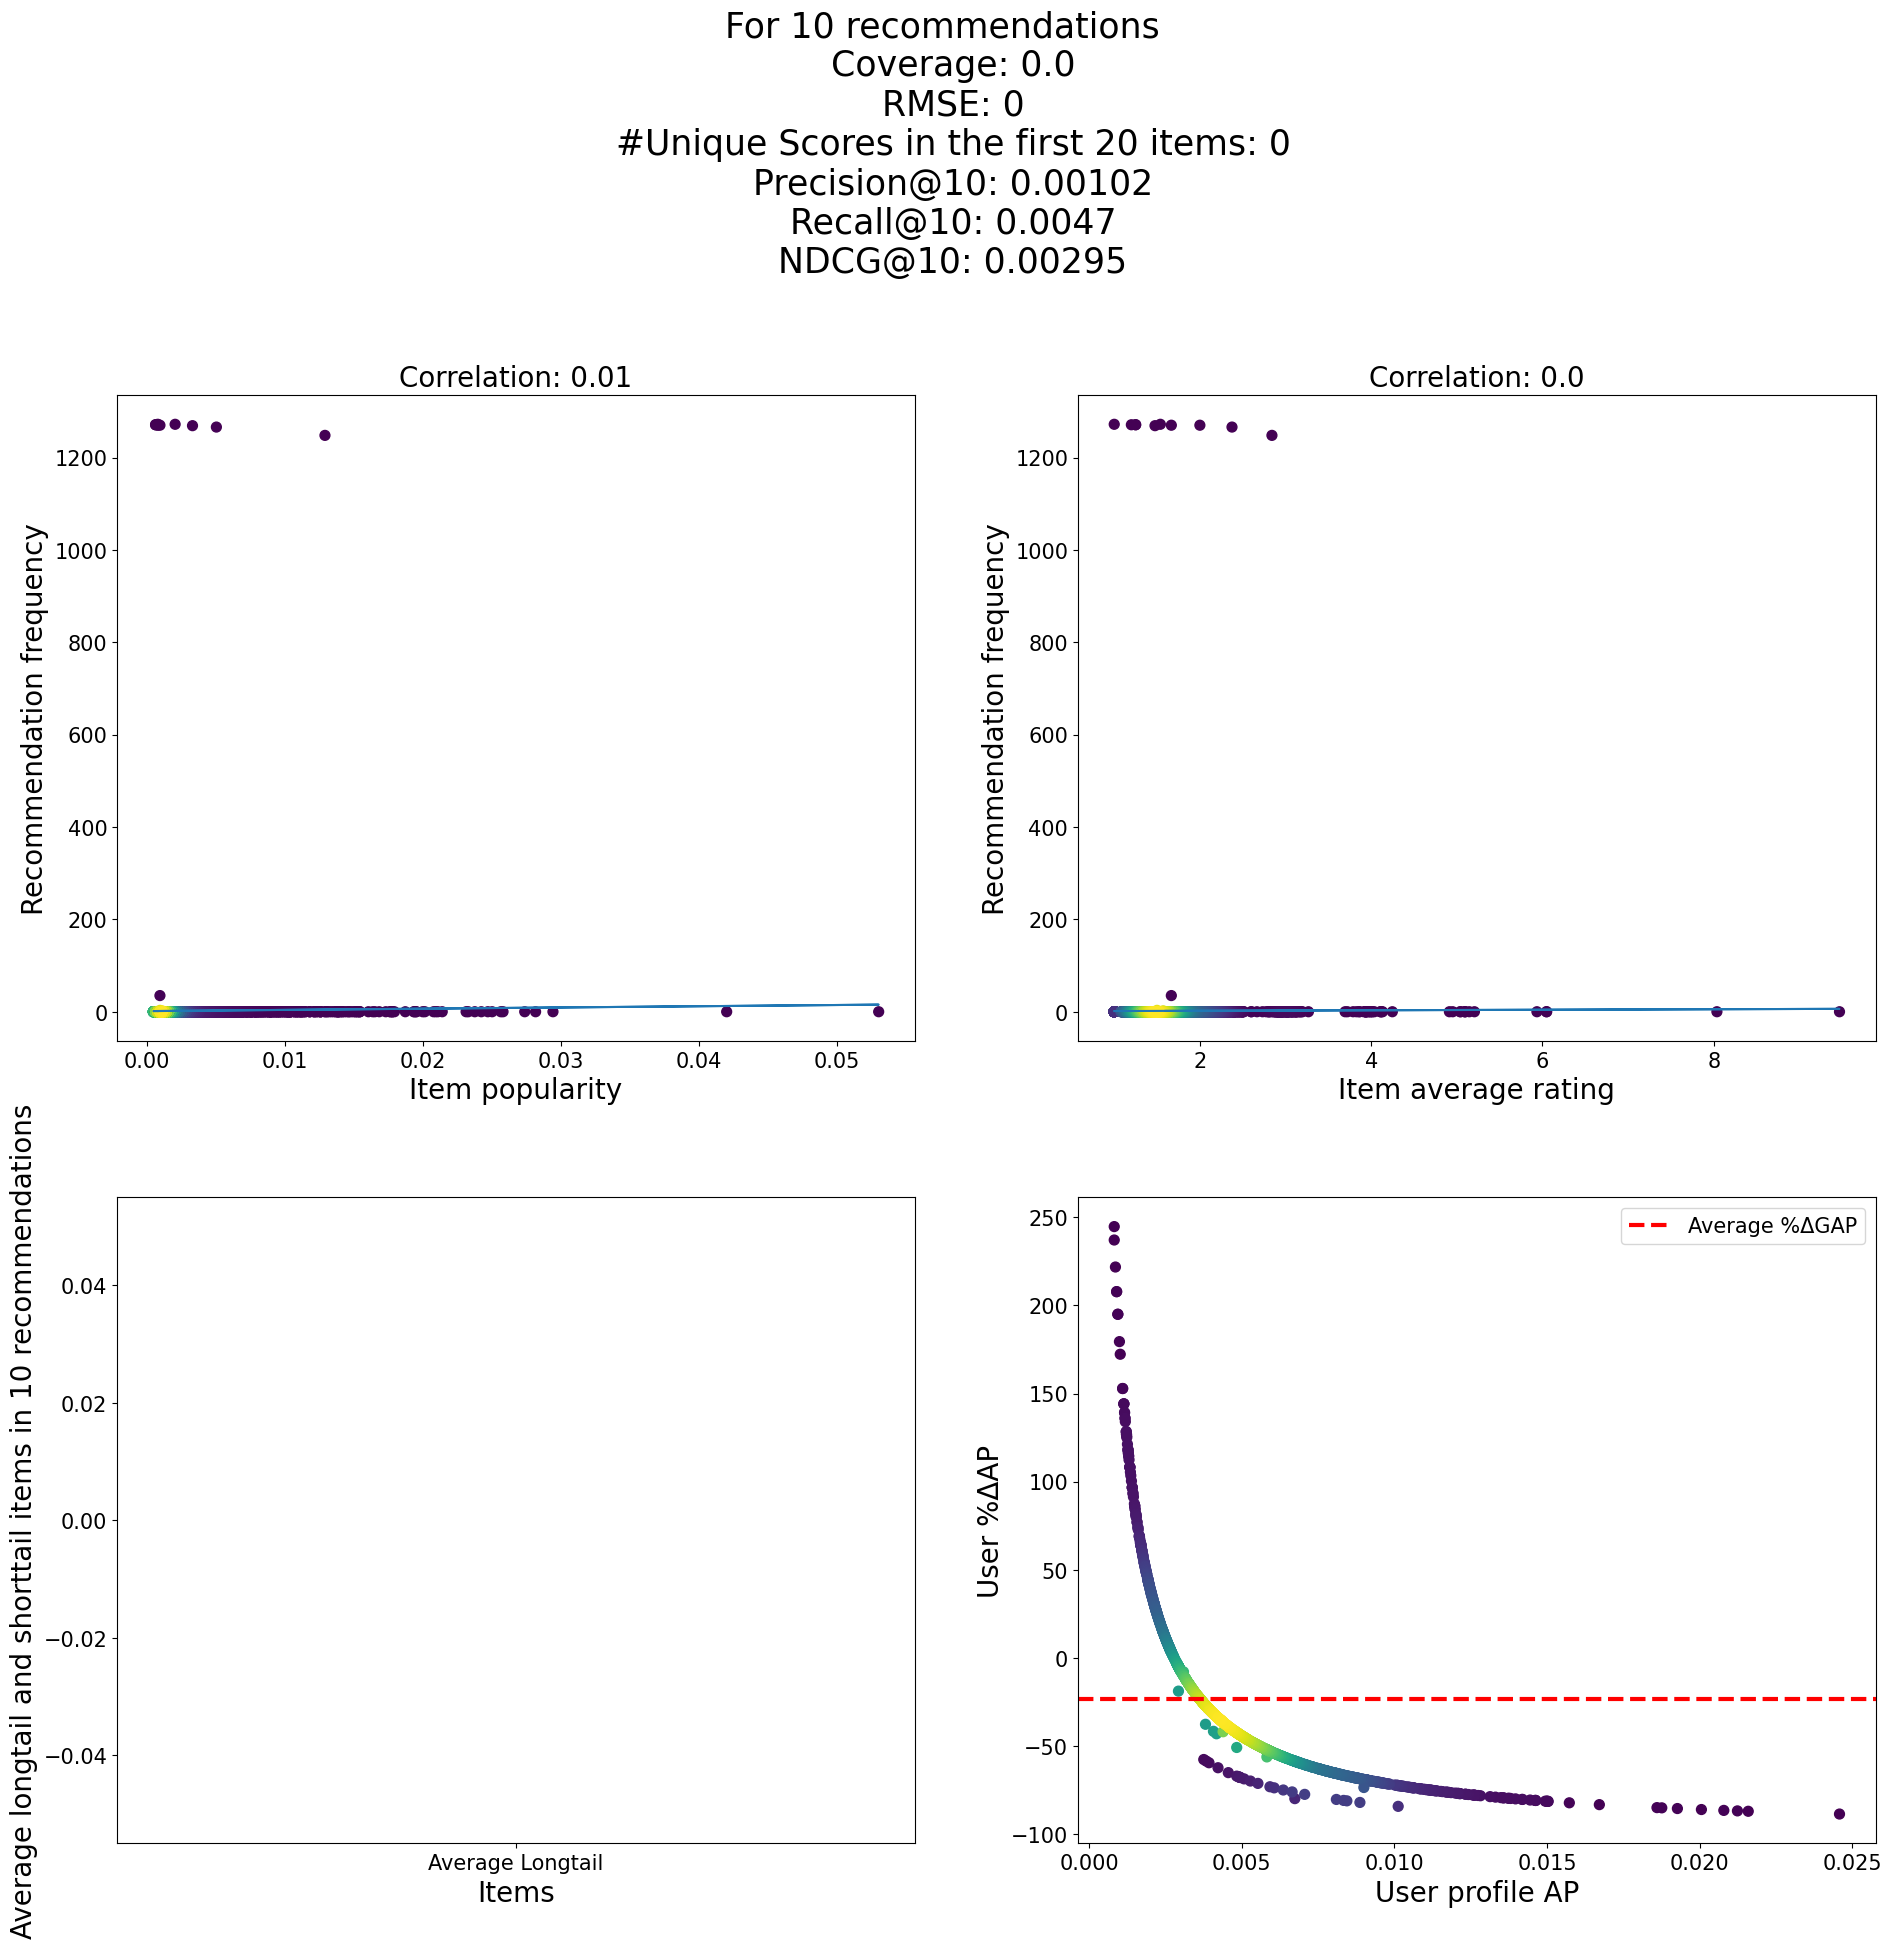

In [74]:
pg_metrics = []
train_df = pd.read_csv('elliot/data/popularity_good/popularity_good_fold_1_train.csv')
test_df = pd.read_csv('elliot/data/popularity_good/popularity_good_fold_1_test.csv')
result_file = location+filename
print(result_file)
test_users = test_df.user.unique()
result_df = pd.read_csv(result_file, sep='\t', header=None)
result_df.columns = ['user','item','rating']



test_result = result_df[result_df.user.isin(test_users)].reset_index(drop=True)
    
    # end = len(test_result)
    # # Create an iterable of indices to keep
    # indices_to_keep = list(chain.from_iterable(range(t, t + keep_interval) for t in range(start, end, keep_interval + skip_interval)))
    # filtered_test_result = test_result.iloc[indices_to_keep].reset_index(drop=True) # keep top 10
filtered_test_result = test_result.copy()
recs_grouped = filtered_test_result.groupby([user_col])[item_col].apply(list)
pop_bias= modelling_mf.calculate_pop_bias_per_item(all_items, item_col, user_col, predict_col, train_df, recs=filtered_test_result)
GAP_vs_GAP = modelling_mf.calculate_ave_pop_per_user(test_users, item_col, user_col, pop_bias, train_df, recs_grouped)
pop_corr = modelling_mf.calculate_pop_correlation(pop_bias)
precision, recall, ndcg = modelling_mf.calculate_topn_metrics(filtered_test_result,test_df)
AggDiv = modelling_mf.evaluate_item_coverage(pop_bias["recommendation"].values)
ARP, ave_PL, ACLT = modelling_mf.calculate_all_pb_metrics(pop_bias, test_users, item_col, user_col, train_df, recs_grouped, filtered_test_result)
metrics_dict_pg = {"pop_corr":pop_corr, "RMSE":0, 'NDCG':ndcg,"ARP":ARP, "ave_PL": ave_PL, "ACLT": ACLT, "AggDiv": AggDiv}
pg_metrics.append(metrics_dict_pg)
pop_biases = [pop_bias]
modelling_mf.plot_results(pop_biases.copy(), 
         GAP_vs_GAP.copy(), 'CornacNGCF',
         0, 
         precision, 
         recall,
         ndcg,
         0,
         0,
         cv=False, 
         n=10, 
         args='fold'+str(1), data_strategy=data_strategies[0], save_plot=False)

In [75]:
precision

0.0010220125786163522

#### Pop bad 1

In [4]:
data="fairbook"
# user-item interactions
fairbook_ratings = pd.read_csv("elliot/data/fairbook/"+data+"_events.csv")

In [5]:
user_col = "user" # the name of the column that includes the users
item_col = "item" # the name of the column that includes the items
predict_col="rating" # the name of the column that includes the interaction

In [6]:
data_strategies = [
                   'popularity_bad',
                   ]

In [7]:
location = 'elliot/results/pop_bad1/recs/'

In [8]:
ratings = generate_data(strategy = data_strategies[0],
                            copying_dataset = fairbook_ratings,
                            user_perc = 0.2)

In [9]:
all_items=set(ratings.item.unique())

In [11]:
filename = 'DMF_seed=42_e=10_bs=512_lr=0$0001_umlp=64-32_imlp=64-32_negratio=5_reg=0$001_sim=cosine_it=3.tsv'

elliot/results/pop_bad1/recs/DMF_seed=42_e=10_bs=512_lr=0$0001_umlp=64-32_imlp=64-32_negratio=5_reg=0$001_sim=cosine_it=3.tsv


2024-02-21 14:41:15.103579: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcudart.so.10.1'; dlerror: libcudart.so.10.1: cannot open shared object file: No such file or directory
2024-02-21 14:41:15.103629: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2024-02-21 14:41:15.240152: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcudart.so.10.1'; dlerror: libcudart.so.10.1: cannot open shared object file: No such file or directory
2024-02-21 14:41:15.240198: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2024-02-21 14:41:15.476752: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcudart.so.10.1'; dlerror: libcudart.so.10.1: cannot open shared object file: No such file or dire

nr of longtail 8173
6.425314465408805


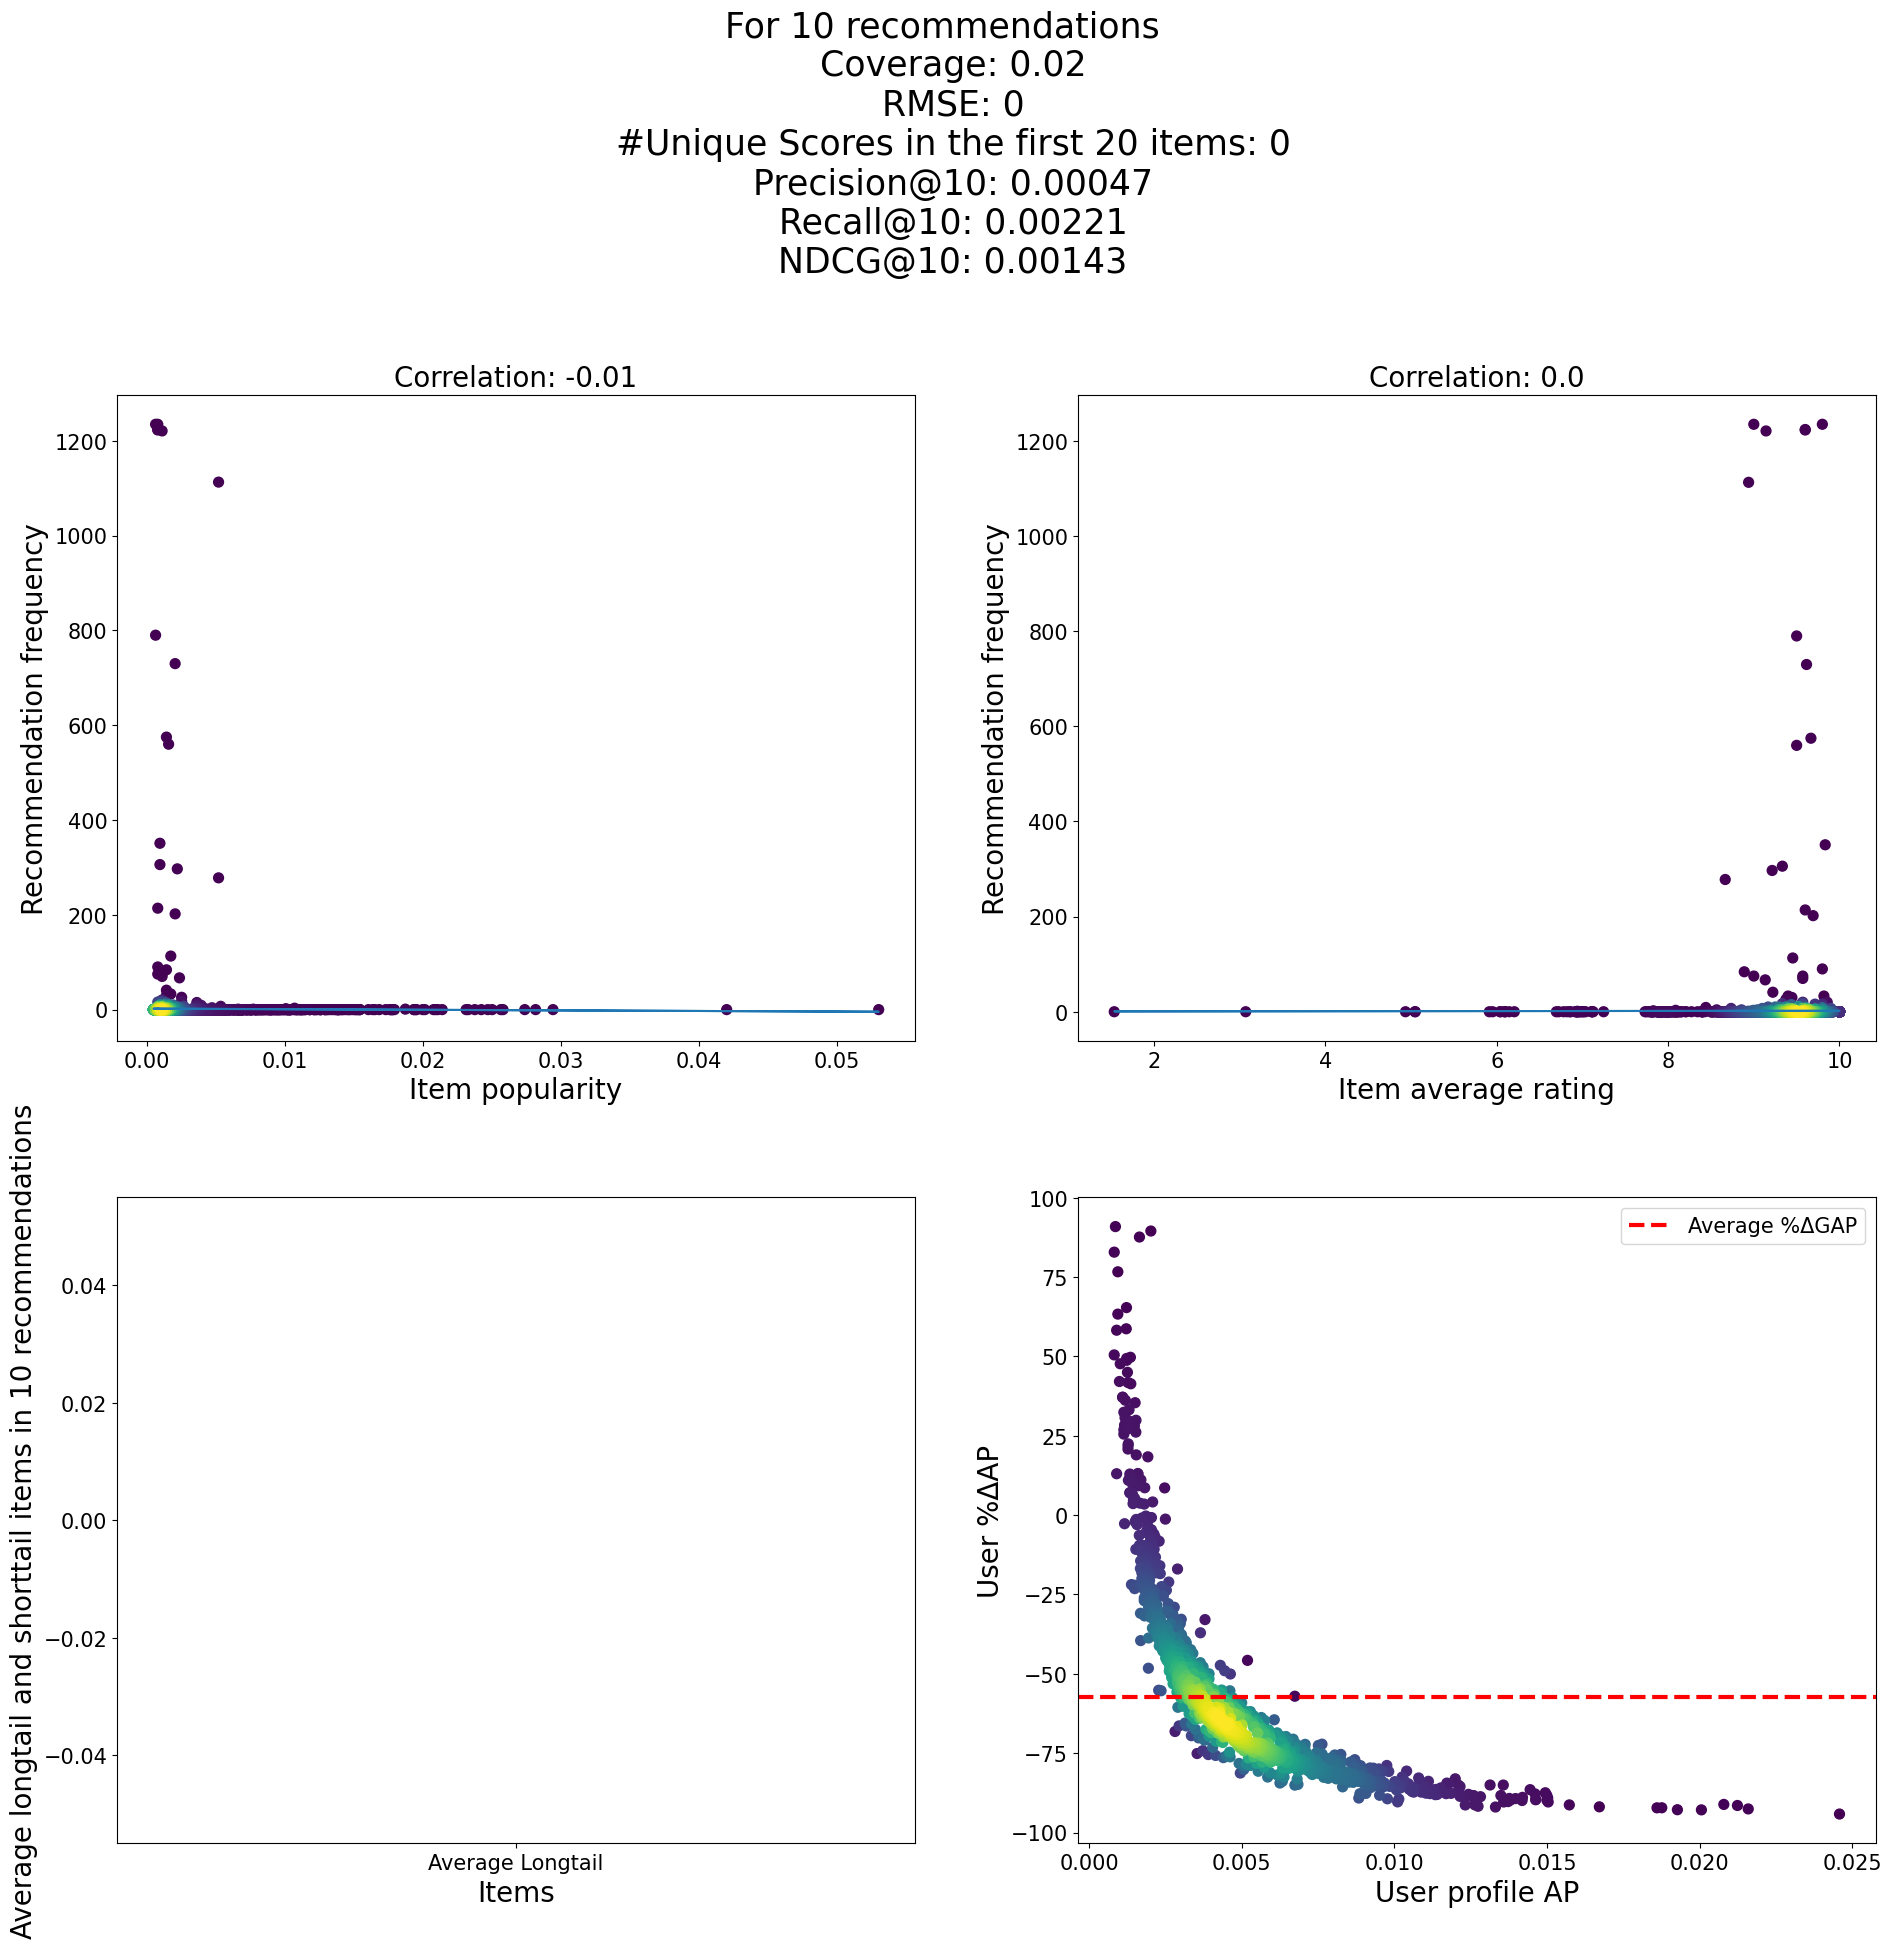

In [12]:
pg_metrics = []
train_df = pd.read_csv('elliot/data/popularity_bad/popularity_bad_fold_1_train.csv')
test_df = pd.read_csv('elliot/data/popularity_bad/popularity_bad_fold_1_test.csv')
result_file = location+filename
print(result_file)
test_users = test_df.user.unique()
result_df = pd.read_csv(result_file, sep='\t', header=None)
result_df.columns = ['user','item','rating']



test_result = result_df[result_df.user.isin(test_users)].reset_index(drop=True)
    
    # end = len(test_result)
    # # Create an iterable of indices to keep
    # indices_to_keep = list(chain.from_iterable(range(t, t + keep_interval) for t in range(start, end, keep_interval + skip_interval)))
    # filtered_test_result = test_result.iloc[indices_to_keep].reset_index(drop=True) # keep top 10
filtered_test_result = test_result.copy()
recs_grouped = filtered_test_result.groupby([user_col])[item_col].apply(list)
pop_bias= modelling_mf.calculate_pop_bias_per_item(all_items, item_col, user_col, predict_col, train_df, recs=filtered_test_result)
GAP_vs_GAP = modelling_mf.calculate_ave_pop_per_user(test_users, item_col, user_col, pop_bias, train_df, recs_grouped)
pop_corr = modelling_mf.calculate_pop_correlation(pop_bias)
precision, recall, ndcg = modelling_mf.calculate_topn_metrics(filtered_test_result,test_df)
AggDiv = modelling_mf.evaluate_item_coverage(pop_bias["recommendation"].values)
ARP, ave_PL, ACLT = modelling_mf.calculate_all_pb_metrics(pop_bias, test_users, item_col, user_col, train_df, recs_grouped, filtered_test_result)
metrics_dict_pg = {"pop_corr":pop_corr, "RMSE":0, 'NDCG':ndcg,"ARP":ARP, "ave_PL": ave_PL, "ACLT": ACLT, "AggDiv": AggDiv}
pg_metrics.append(metrics_dict_pg)
pop_biases = [pop_bias]
modelling_mf.plot_results(pop_biases.copy(), 
         GAP_vs_GAP.copy(), 'CornacNGCF',
         0, 
         precision, 
         recall,
         ndcg,
         0,
         0,
         cv=False, 
         n=10, 
         args='fold'+str(1), data_strategy=data_strategies[0], save_plot=False)

#### Pop Bad Big 1

In [19]:
data_strategies = [
                   'popularity_bad_for_bp_ur',
                   ]

In [17]:
location = 'elliot/results/pop_bad_big1/recs/'

In [20]:
ratings = generate_data(strategy = data_strategies[0],
                            copying_dataset = fairbook_ratings,
                            user_perc = 0.2)

In [21]:
all_items=set(ratings.item.unique())

In [22]:
filename = 'DMF_seed=42_e=10_bs=512_lr=0$0001_umlp=64-32_imlp=64-32_negratio=5_reg=0$001_sim=cosine_it=1.tsv'

elliot/results/pop_bad_big1/recs/DMF_seed=42_e=10_bs=512_lr=0$0001_umlp=64-32_imlp=64-32_negratio=5_reg=0$001_sim=cosine_it=1.tsv


2024-02-21 15:05:33.572707: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcudart.so.10.1'; dlerror: libcudart.so.10.1: cannot open shared object file: No such file or directory
2024-02-21 15:05:33.572749: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2024-02-21 15:05:33.798599: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcudart.so.10.1'; dlerror: libcudart.so.10.1: cannot open shared object file: No such file or directory
2024-02-21 15:05:33.798631: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2024-02-21 15:05:33.992043: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcudart.so.10.1'; dlerror: libcudart.so.10.1: cannot open shared object file: No such file or dire

nr of longtail 3589
2.8215408805031448


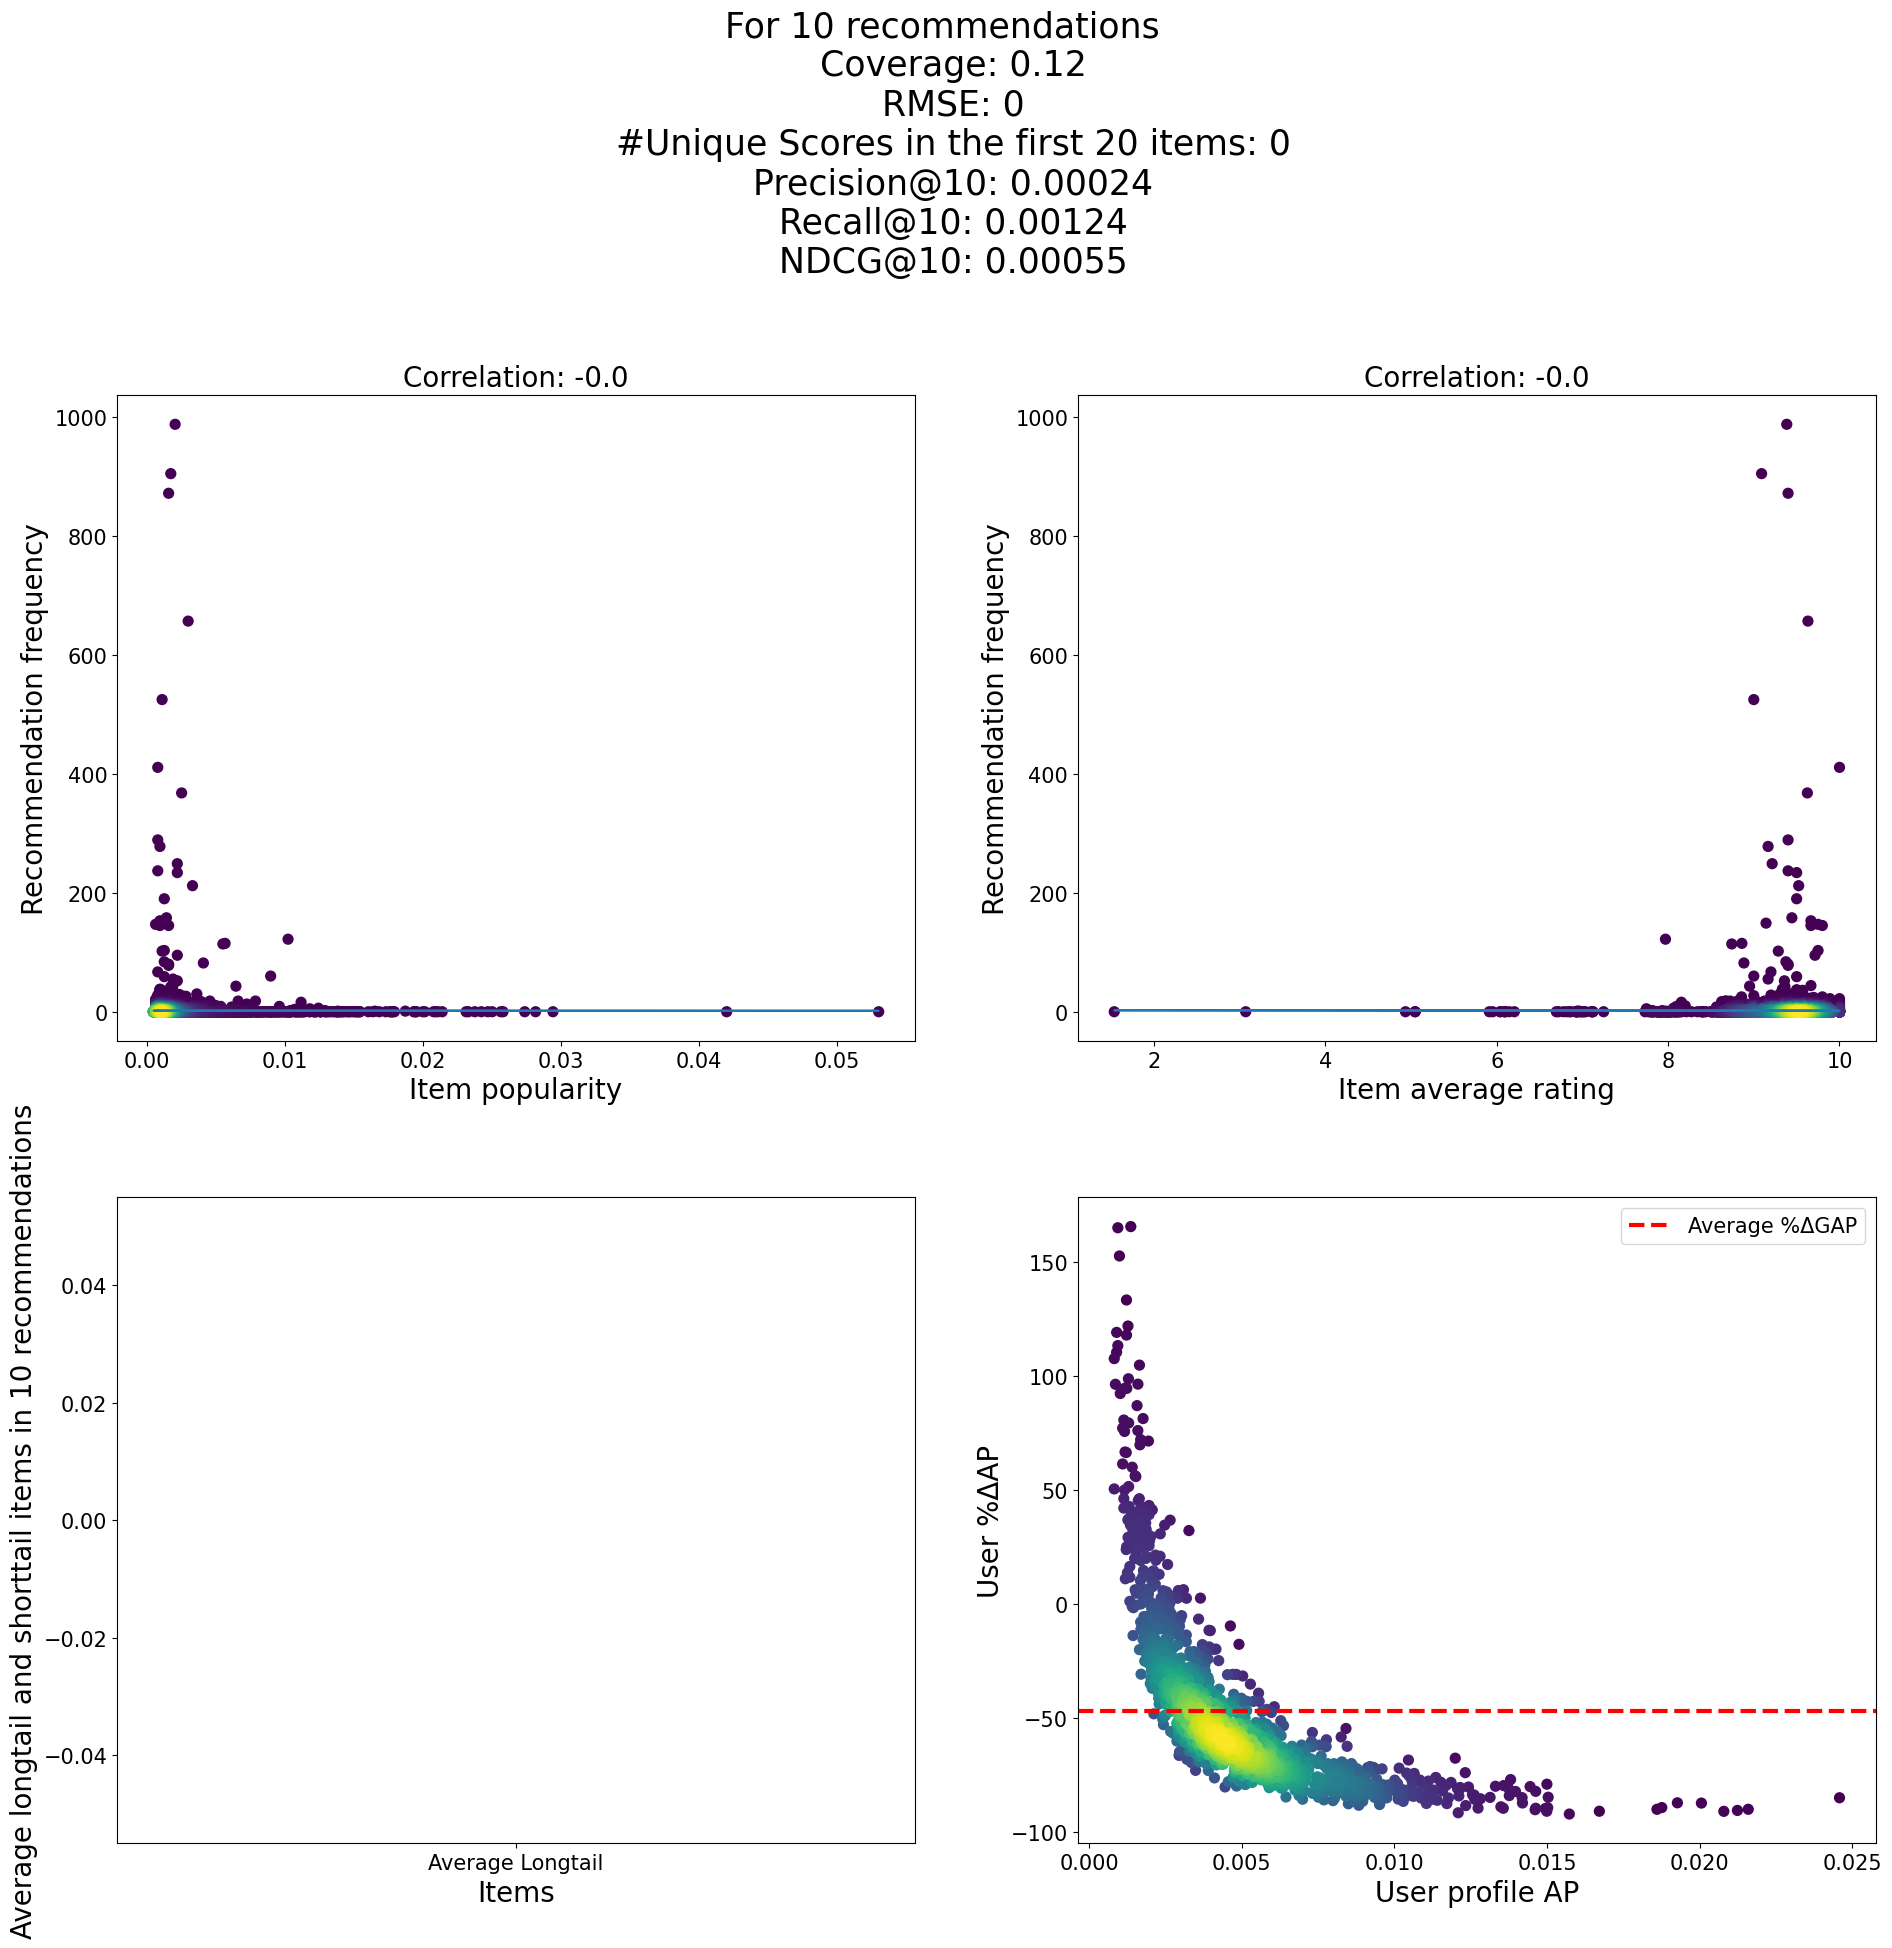

In [24]:
pg_metrics = []
train_df = pd.read_csv('elliot/data/popularity_bad/popularity_bad_fold_1_train.csv')
test_df = pd.read_csv('elliot/data/popularity_bad/popularity_bad_fold_1_test.csv')
result_file = location+filename
print(result_file)
test_users = test_df.user.unique()
result_df = pd.read_csv(result_file, sep='\t', header=None)
result_df.columns = ['user','item','rating']



test_result = result_df[result_df.user.isin(test_users)].reset_index(drop=True)
    
    # end = len(test_result)
    # # Create an iterable of indices to keep
    # indices_to_keep = list(chain.from_iterable(range(t, t + keep_interval) for t in range(start, end, keep_interval + skip_interval)))
    # filtered_test_result = test_result.iloc[indices_to_keep].reset_index(drop=True) # keep top 10
filtered_test_result = test_result.copy()
recs_grouped = filtered_test_result.groupby([user_col])[item_col].apply(list)
pop_bias= modelling_mf.calculate_pop_bias_per_item(all_items, item_col, user_col, predict_col, train_df, recs=filtered_test_result)
GAP_vs_GAP = modelling_mf.calculate_ave_pop_per_user(test_users, item_col, user_col, pop_bias, train_df, recs_grouped)
pop_corr = modelling_mf.calculate_pop_correlation(pop_bias)
precision, recall, ndcg = modelling_mf.calculate_topn_metrics(filtered_test_result,test_df)
AggDiv = modelling_mf.evaluate_item_coverage(pop_bias["recommendation"].values)
ARP, ave_PL, ACLT = modelling_mf.calculate_all_pb_metrics(pop_bias, test_users, item_col, user_col, train_df, recs_grouped, filtered_test_result)
metrics_dict_pg = {"pop_corr":pop_corr, "RMSE":0, 'NDCG':ndcg,"ARP":ARP, "ave_PL": ave_PL, "ACLT": ACLT, "AggDiv": AggDiv}
pg_metrics.append(metrics_dict_pg)
pop_biases = [pop_bias]
modelling_mf.plot_results(pop_biases.copy(), 
         GAP_vs_GAP.copy(), 'CornacNGCF',
         0, 
         precision, 
         recall,
         ndcg,
         0,
         0,
         cv=False, 
         n=10, 
         args='fold'+str(1), data_strategy=data_strategies[0], save_plot=False)